<a href="https://colab.research.google.com/github/kalmuroth/lb-cml/blob/main/lb_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Random Forest for Fraud Detection with SciKit-Learn

In [80]:
!pip install h2o

In [81]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import h2o
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,27 mins 17 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_ts8pnx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.646 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [82]:
data = pd.read_csv('./drive/MyDrive/notebook/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [83]:
address2country = pd.read_csv('./drive/MyDrive/notebook/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [84]:
# Merge the two datasets based on IP address range
merged_data = pd.concat([data, address2country], axis=1)
print(merged_data.head())

   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   

   lower_bound_ip_address  upper_bound_ip_address    country  
0              16777216.0              16777471.0  Australia  
1              16777472.0              16777727.0      China  

In [85]:
# Get the time difference between purchase time and signup time
merged_data['time_difference'] = merged_data['purchase_time'] - merged_data['signup_time']

# Create a new DataFrame with selected columns
new_dataframe = merged_data[['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source',
                             'browser', 'sex', 'age', 'ip_address', 'class', 'country', 'time_difference']]

# Print the first 5 rows of the new DataFrame
print(new_dataframe.head())


   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class    country  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  Australia   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0      China   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1      China   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  Australia   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0      China   

   time_difference  
0 52 days 03:51:22  
1  0 days 04:59:04  
2  0 days 00:00:01  
3  5 days 16:41:25  
4 50 days 11:31:0

In [86]:
# Check user number for unique devices
unique_devices_per_user = merged_data.groupby('user_id')['device_id'].nunique()
print(unique_devices_per_user)

user_id
2         1
4         1
8         1
9         1
12        1
         ..
399992    1
399993    1
399995    1
399997    1
400000    1
Name: device_id, Length: 151112, dtype: int64


In [87]:
# Check user number for unique ip_address
unique_ips_per_user = merged_data.groupby('user_id')['ip_address'].nunique()
print(unique_ips_per_user)

user_id
2         1
4         1
8         1
9         1
12        1
         ..
399992    1
399993    1
399995    1
399997    1
400000    1
Name: ip_address, Length: 151112, dtype: int64


In [88]:
# Signup day and week
# Purchase day and week
merged_data['signup_day'] = merged_data['signup_time'].dt.day_name()
merged_data['signup_week'] = merged_data['signup_time'].dt.isocalendar().week

# Extract purchase day and week
merged_data['purchase_day'] = merged_data['purchase_time'].dt.day_name()
merged_data['purchase_week'] = merged_data['purchase_time'].dt.isocalendar().week

# Print the first 5 rows with the new columns
print(merged_data[['user_id', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week']].head())

   user_id signup_day  signup_week purchase_day  purchase_week
0    22058    Tuesday            9     Saturday             16
1   333320     Sunday           23       Monday             24
2     1359   Thursday            1     Thursday              1
3   150084    Tuesday           18       Monday             19
4   221365    Tuesday           30    Wednesday             37


In [89]:
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,16777216.0,16777471.0,Australia,52 days 03:51:22,Tuesday,9,Saturday,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,16777472.0,16777727.0,China,0 days 04:59:04,Sunday,23,Monday,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,16777728.0,16778239.0,China,0 days 00:00:01,Thursday,1,Thursday,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,16778240.0,16779263.0,Australia,5 days 16:41:25,Tuesday,18,Monday,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,16779264.0,16781311.0,China,50 days 11:31:01,Tuesday,30,Wednesday,37


In [90]:
# Define features and target to be used
features = ['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_difference', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week']
target = 'class'

X = merged_data[features]
y = merged_data[target]

merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,16777216.0,16777471.0,Australia,52 days 03:51:22,Tuesday,9,Saturday,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,16777472.0,16777727.0,China,0 days 04:59:04,Sunday,23,Monday,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,16777728.0,16778239.0,China,0 days 00:00:01,Thursday,1,Thursday,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,16778240.0,16779263.0,Australia,5 days 16:41:25,Tuesday,18,Monday,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,16779264.0,16781311.0,China,50 days 11:31:01,Tuesday,30,Wednesday,37


In [108]:
from sklearn.model_selection import train_test_split
# Split into 70% training and 30% test dataset
# Define features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shape of training and test sets
print("Training set shape - X_train:", X_train.shape, "y_train:", y_train.shape)

print("Test set shape - X_test:", X_test.shape, "y_test:", y_test.shape)

Training set shape - X_train: (105778, 11) y_train: (105778,)
Test set shape - X_test: (45334, 11) y_test: (45334,)


In [117]:
# Define features and target
features = ['purchase_value', 'age', 'time_difference', 'signup_week', 'purchase_week',
            'source', 'browser', 'sex', 'country', 'signup_day', 'purchase_day']
predictors = features

target = 'class'

drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
drf.train(x=predictors, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1693469856260_8


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          2.71092e+06            20           20           20            1790          3980          3140.34

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.043295842224706164
RMSE: 0.2080765297305445
MAE: 0.083606161939239
RMSLE: 0.14691412509897828
Mean Residual Deviance: 0.043295842224706164

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.04249088160544996
RMSE: 0.20613316473932564
MAE: 0.08380499256395085
RMSLE: 0.14469655979609092
Mean Residual Deviance: 0.04249088160544996

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.0838084  0.00165936  0.0849519     0.0856281     0.0840503     0.0807072     0.0831949     0.0822462     0.0860838     0.0837412     0.082627      0.0848531
mean_residual_deviance  0.0424954  0.00173466  0.0435756     0.0443203     0.0430169     0.0391199     0.0415696     0.0411134     0.0449743     0.0422192     0.0415403     0.0435043
mse                     0.0424954  0.00173466  0.0435756     0.0443203     0.0430169     0.0391199     0.0415696     0.0411134     0.0449743     0.0422192     0.0415403     0.0435043
r2                      0.497988   0.01466     0.482009      0.498008      0.490756      0.526084      0.487528      0.500585      0.490774      0.514943      0.507987      0.481208
residual_deviance       0.0424954  0.00173466  0.0435756     0.0443203     0.0430169     0.0391199     0.0415696     0.0411134     0.0449743     0.0422192     0.0415403     0.0435043
rmse                    0.206105   0.00422714  0.208748      0.210524      0.207405      0.197787      0.203886      0.202764      0.212071      0.205473      0.203814      0.208577
rmsle                   0.14468    0.0027492   0.146355      0.147643      0.145421      0.139315      0.143344      0.142386      0.148522      0.144203      0.143218      0.146392

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2023-08-31 09:01:14  2 min 50.930 sec  0                  nan              nan             nan
    2023-08-31 09:01:15  2 min 51.329 sec  1                  0.263412         0.082848        0.0693858
    2023-08-31 09:01:15  2 min 51.544 sec  2                  0.250004         0.0839525       0.0625022
    2023-08-31 09:01:15  2 min 51.755 sec  3                  0.244096         0.0835571       0.0595827
    2023-08-31 09:01:16  2 min 52.178 sec  4                  0.239522         0.0839192       0.0573708
    2023-08-31 09:01:16  2 min 52.662 sec  5                  0.236808         0.0835586       0.056078
    2023-08-31 09:01:17  2 min 53.155 sec  6                  0.232846         0.0835079       0.0542171
    2023-08-31 09:01:17  2 min 53.662 sec  7                  0.228166         0.0830892       0.0520597
    2023-08-31 09:01:18  2 min 54.112 sec  8                  0.226179         0.0832146       0.0511569
    2023-08-31 09:01:18  2 min 54.672 sec  9                  0.224309         0.0835989       0.05031

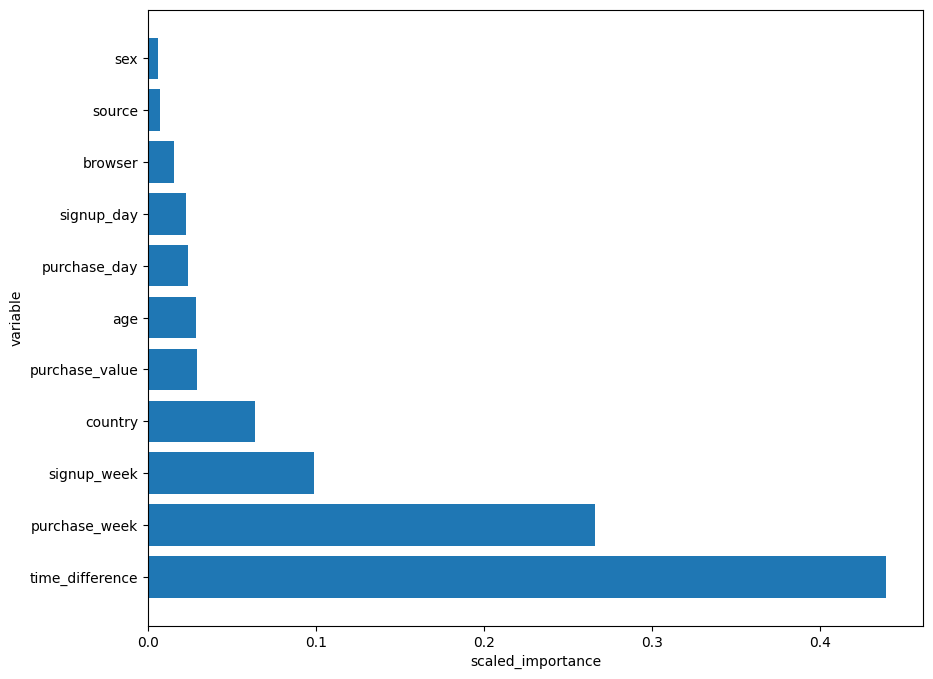

In [118]:
# Feature importance
feature_imp = drf.varimp(use_pandas=True)
feature_imp = feature_imp.sort_values(by='percentage', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['variable'], feature_imp['percentage'])
plt.xlabel('scaled_importance')
plt.ylabel('variable')
plt.savefig("Importances.png")